# Reproducing U-Net
**bold text**

Abstract

## U-Net Explained


Short overview of how UNet works.

## Experiments

- Which results do we want to replicate?
- What are we adding?  
  - PyTorch/Keras comparison
  - Adadelta vs SGD with learning rate decay


## Code

Add runnable code with explanations.

## Imports & Installs

In [1]:
!pip install torch torchvision
!pip install -q elasticdeform

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
from torch import nn

import os
import time
import math
import glob


import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import numpy as np
np.random.seed(1)


from PIL import Image, ImageSequence
from pathlib import Path

from scipy.ndimage.interpolation import rotate

from typing import Tuple

from google.colab import files

import elasticdeform

## Data

Download data you would like to use.


In [0]:
os.environ['KAGGLE_USERNAME'] = "sranjha" # username from the json file
os.environ['KAGGLE_KEY'] = "57d3733a9bceac9771f0295b9f791080" # key from the json file

### Huge dataset

In [0]:
if False:
  !kaggle datasets download sranjha/augmented-segmentation-challenge-dataset
  !unzip -q /content/augmented-segmentation-challenge-dataset.zip -d augmented-segmentation-challenge-dataset

### Smaller datsets


In [4]:
if not Path('/content/tiny-augmented-segmentation-challenge-dataset.zip').exists():
  !kaggle datasets download sranjha/tiny-augmented-segmentation-challenge-dataset
  !unzip -q /content/tiny-augmented-segmentation-challenge-dataset.zip -d tiny-augmented-segmentation-challenge-dataset

 73% 49.0M/67.0M [00:01<00:00, 26.1MB/s]
100% 67.0M/67.0M [00:01<00:00, 38.6MB/s]


In [5]:
if not Path('/content/rotated-tiny-augmented-segmentation-challenge-data.zip').exists():
  !kaggle datasets download sranjha/rotated-tiny-augmented-segmentation-challenge-data
  !unzip -q /content/rotated-tiny-augmented-segmentation-challenge-data.zip -d rotated-tiny-augmented-segmentation-challenge-data

 81% 121M/149M [00:03<00:00, 44.6MB/s]
100% 149M/149M [00:04<00:00, 38.7MB/s]


In [6]:
if not Path('/content/split-tiny-augmented-segmentation-challenge-data.zip').exists():
  !kaggle datasets download sranjha/split-tiny-augmented-segmentation-challenge-data
  !unzip -q /content/split-tiny-augmented-segmentation-challenge-data.zip -d split-tiny-augmented-segmentation-challenge-data

 90% 60.0M/67.0M [00:03<00:00, 18.2MB/s]
100% 67.0M/67.0M [00:03<00:00, 21.8MB/s]


In [7]:
if not Path('/content/50x-augmented-segmentation-challenge-data.zip').exists():
  !kaggle datasets download sranjha/50x-augmented-segmentation-challenge-data
  !unzip -q /content/50x-augmented-segmentation-challenge-data.zip -d 50x-augmented-segmentation-challenge-data

 99% 665M/670M [00:17<00:00, 47.9MB/s]
100% 670M/670M [00:17<00:00, 41.0MB/s]


## Data Augmentation

Sayra add explanation here

In [0]:
def makedir(path: str):
    """
    Creates a directory with the specified path if it does not exist yet.

    Params
    ------
    path: str
        the file path of the directory that should be created
    """
    current_directory = os.getcwd()
    final_directory = os.path.join(current_directory, rf'{path}')
    if not os.path.exists(final_directory):
        os.makedirs(final_directory)


def make_data_dirs(path: str, factor: int) -> Tuple[str, str, str, str]:
    """
    Creates the directories for the training and test datasets.

    Params
    ------
    path: str
        the file path to the directory in which the new directories should be created
    factor: int
        the factor with which the size of the dataset is increased
    """
    train_output_path = f'{path}/augmented/train_{factor}x'
    train_label_output_path = f'{path}/augmented/train_labels_{factor}x'
    test_output_path = f'{path}/augmented/test_{factor}x'
    test_label_output_path = f'{path}/augmented/test_labels_{factor}x'
    makedir(train_output_path)
    makedir(train_label_output_path)
    makedir(test_output_path)
    makedir(test_label_output_path)

    return train_output_path, train_label_output_path, test_output_path, test_label_output_path


def crop_center(image: Image, width: int, height: int) -> Image:
    """
    Crops an image from the center to have the specified width and height.

    Params
    ------
    image: Image
        a PIL.Image that represents the image to be cropped
    width: int
        the width the image should be cropped to
    height: int
        the height the image should be cropped to
    Returns
    ------
    Image
        the cropped image
    """
    y, x = image.shape
    start_x = x // 2 - (width // 2)
    start_y = y // 2 - (height // 2)
    return image[start_y:start_y + height, start_x:start_x + width]


def augment_image(image: Image, label: Image, output_size: Tuple[int, int] = (700, 700), rotation: bool = False) -> Tuple[np.array, np.array]:
    """ Augments an image and its label using the same transformations. First the images are padded by mirroring the
    image along the borders. This is to ensure that the pixels in the border region of the image will have enough
    context during convolution.

    Elastic deformations are performed over a 3x3 grid. The displacements are sampled from a Gaussian distribution with
    a standard deviation of 10 pixels.

    Finally, the images are cropped to the output size to remove any artifacts on the image borders caused by the
    elastic deformation.

    Params
    ------
    image: Image
        a PIL.Image that represents the image to be augmented
    label: Image
        a PIL.Image that represents the label of the image to be augmented
    output_size: (int, int)
        represents the size the augmented images should be when they are returned
    rotation: bool
        whether to apply rotations on the image and label

    Returns
    ------
    image_array, label_array: Tuple[np.array, np.array]
        the augmented image and label
    """
    image_array = np.array(image)
    label_array = np.array(label)

    # Ensure there is enough padding in case output size = image size
    pad_width = output_size[0] - image_array.shape[0] + 200
    pad_height = output_size[1] - image_array.shape[1] + 200

    image_array = np.pad(image_array, pad_width=[(pad_width, pad_width), (pad_height, pad_height)], mode='symmetric')
    label_array = np.pad(label_array, pad_width=[(pad_width, pad_width), (pad_height, pad_height)], mode='symmetric')

    if rotation:
        image_array = rotate(image_array, angle=45)
        label_array = rotate(label_array, angle=45)

    image_array, label_array = elasticdeform.deform_random_grid([image_array, label_array], sigma=10, points=3,
                                                                order=[3, 0])

    image_array = crop_center(image_array, output_size[0], output_size[1])
    label_array = crop_center(label_array, output_size[0], output_size[1])

    return image_array, label_array


def augment_segmentation_dataset(factor: int):
    """ Augments the ISBI Challenge Segmentation dataset.

    Params
    ------
    factor: int
        the factor with which the size of the dataset should increase
    """
    train, train_label, test, test_label = make_data_dirs("segmentation_challenge_data", factor)

    training_image_volume = Image.open("segmentation_challenge_data/train-volume.tif")
    training_label_volume = Image.open("segmentation_challenge_data/train-labels.tif")

    images = []
    labels = []
    for image in ImageSequence.Iterator(training_image_volume):
        images.append(image.copy())

    for label in ImageSequence.Iterator(training_label_volume):
        labels.append(label.copy())

    augment_dataset(factor, images, labels, train, train_label, test, test_label)


def augment_phc_dataset(factor: int):
    """ Augments the PhC-U373 dataset.

    Params
    ------
    factor: int
        the factor with which the size of the dataset should increase
    """
    train, train_label, test, test_label = make_data_dirs("cell_tracking_challenge_data/PhC-C2DH-U373_train", factor)

    images = list(map(Image.open, glob.glob('cell_tracking_challenge_data/PhC-C2DH-U373_train/01/*.tif')))
    images.extend(list(map(Image.open, glob.glob('cell_tracking_challenge_data/PhC-C2DH-U373_train/02/*.tif'))))
    labels = list(map(Image.open, glob.glob('cell_tracking_challenge_data/PhC-C2DH-U373_train/01_GT/*.tif')))
    labels.extend(list(map(Image.open, glob.glob('cell_tracking_challenge_data/PhC-C2DH-U373_train/02_GT/*.tif'))))

    augment_dataset(factor, images, labels, train, train_label, test, test_label)


def augment_dic_dataset(factor: int):
    """ Augments the DIC-HeLa dataset.

    Params
    ------
    factor: int
        the factor with which the size of the dataset should increase
    """
    train, train_label, test, test_label = make_data_dirs("cell_tracking_challenge_data/DIC-C2DH-HeLa_train", factor)

    images = list(map(Image.open, glob.glob('cell_tracking_challenge_data/DIC-C2DH-HeLa_train/01/*.tif')))
    images.extend(list(map(Image.open, glob.glob('cell_tracking_challenge_data/DIC-C2DH-HeLa_train/02/*.tif'))))
    labels = list(map(Image.open, glob.glob('cell_tracking_challenge_data/DIC-C2DH-HeLa_train/01_GT/*.tif')))
    labels.extend(list(map(Image.open, glob.glob('cell_tracking_challenge_data/DIC-C2DH-HeLa_train/02_GT/*.tif'))))

    augment_dataset(factor, images, labels, train, train_label, test, test_label)


def augment_dataset(factor: int, images: [Image], labels: [Image], train_path: str, train_label_path: str,
                    test_path: str, test_label_path: str):
    """ Augments a dataset by augmenting each image in the dataset a `factor` number of times. The dataset is split in
    a train and test set and all augmented images are saved in their respective folders.

    Params
    ------
    factor: int
        the factor with which the size of the dataset should increase
    images: [Image]
        an array of PIL.Image that represents the images to be augmented
    labels: [Image]
        an array of PIL.Image that represents the labels of the images to be augmented
    train_path: str
        the path the images from the training set should be saved to
    train_label_path: str
        the path the labels from the training set should be saved to
    test_path: str
        the path the images from the test set should be saved to
    test_label_path: str
        the path the labels from the test set should be saved to
    """
    test_cut = math.floor(len(images) * 0.1)

    for i, (image, label) in enumerate(zip(images, labels)):
        if i < test_cut:
            for j in range(factor):
                augmented_image, augmented_label = augment_image(image, label)
                Image.fromarray(augmented_image).save(f"{test_path}/test_{j}_{i}.tif", "tiff")
                Image.fromarray(augmented_label).save(f"{test_label_path}/label_{j}_{i}.tif", "tiff")

                # augmented_image, augmented_label = augment_image(image, label, rotation=True)
                # Image.fromarray(augmented_image).save(f"{test_path}/test_rotated_{j}_{i}.tif", "tiff")
                # Image.fromarray(augmented_label).save(f"{test_label_path}/label_rotated_{j}_{i}.tif", "tiff")
        else:
            for j in range(factor):
                augmented_image, augmented_label = augment_image(image, label)
                Image.fromarray(augmented_image).save(f"{train_path}/train_{j}_{i}.tif", "tiff")
                Image.fromarray(augmented_label).save(f"{train_label_path}/label_{j}_{i}.tif", "tiff")

                # augmented_image, augmented_label = augment_image(image, label, rotation=True)
                # Image.fromarray(augmented_image).save(f"{train_path}/train_rotated_{j}_{i}.tif", "tiff")
                # Image.fromarray(augmented_label).save(f"{train_label_path}/label_rotated_{j}_{i}.tif", "tiff")

## Evaluation Methods

Different methods that are used for the evaluation of the results.

In [0]:
def pixel_error(output: np.ndarray, label: np.ndarray):
  """Calculates the percentage of pixels that were NOT correctly classified.

  Params
  ------
  output: np.ndarray
    a 2-dimensional integer array in which the background pixels are labeled with a 1
    representing the predicted labels

  label: np.ndarray
    a 2-dimensional integer array in which the background pixels are labeled with a 1
    representing the true labels
  
  """
  
  return np.sum(output != label)/output.size

def intersection_over_union(predicted: np.ndarray, label: np.ndarray):
  """Calculates the intersection over union of the output and the true label.

  Params
  ------
  predicted: np.ndarray
    a 2-dimensional integer array in which the background pixels are labeled 
    with a 1; represents the predicted labels

  label: np.ndarray
    a 2-dimensional integer array in which the background pixels are labeled 
    with a 1; represents the true labels
  
  """
  
  intersection = (predicted & label).sum((0,1))
  union = (predicted | label).sum((0,1))
  return intersection / union


def binary_mask(image: np.ndarray, chan = 1):
  """Apply mask to image. Every value over 0.5 becomes a 1, every value
  under 0.5 becomes a 0.
  
  Params
  ------
  image: np.ndarray
    a H X W X C image; H is height, W is width, C is channels (assumed to be 2)

  chan: int
    whether the correct labelings can be found in channel 0 or 1
  """

  masked = image[:,:,chan]
  masked[masked < 0.5] = 0
  masked[masked >= 0.5] = 1
  return masked.astype('int')

def argmax_mask(image: np.ndarray):
  masked = image


def plot_learning_curve(train_losses: list, test_losses: list, title: str, save_plot = False):
  iterations = range(0, len(train_losses))
  plt.figure(figsize=(20,15))
  plt.plot(iterations, train_losses, label= "train")
  plt.plot(iterations, test_losses, label= "test")
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  if save_plot:
    plt.savefig(f"/content/drive/My Drive/{title}.png")
  plt.show()

# Keras Implementation

# PyTorch Implementation

### Utility Methods



In [0]:
def center_crop_feature_map(feature_map: torch.Tensor, target_tensor: torch.Tensor) -> torch.Tensor:
  """Center crop a feature map in the x, y dimension to match the size of the 
  target tensor.
  
  Params
  ------
  feature_map: torch.Tensor
    an 1 x 1 x H x W tensor representing a feature map

  target_tensor: torch.Tensor
    an 1 x 1 x H_crop x W_crop tensor whose size should be matched

  Returns
  -------
  torch.Tensor
    the feature_map center cropped to 1 x 1 x H_crop x W_crop

  """
 
  _, _, feature_map_height, feature_map_width = feature_map.size()
  _, _, target_height, target_width = target_tensor.size()
  diff_y = (feature_map_height - target_height) // 2
  diff_x = (feature_map_width - target_width) // 2

  
  return feature_map[
          :, :, diff_y: (diff_y + target_height), diff_x: (diff_x + target_width)
          ]

def center_crop_image_tensor(in_tensor: torch.Tensor, target_dim: Tuple[int, int]) -> torch.Tensor:
  """Center crop an image tensor in the x, y dimension to match the target
  dimensions.

  Params
  ------
  in_tensor: torch.Tensor
    a 1 x H x W tensor representing an image

  target_dim: Tuple[int, int]
    contains the target dimensions, H_crop and W_crop

  Returns
  -------
  torch.Tensor
    the in_tensor center cropped to 1 x H_crop x W_crop

  """

  _, input_height, input_width = in_tensor.size()

  diff_y = (input_height - target_dim[0]) // 2
  diff_x = (input_width - target_dim[1]) // 2


  return in_tensor[:, diff_y : diff_y + target_dim[0], diff_x : diff_x + target_dim[1]]

def get_loss(data_loader: DataLoader, net: nn.Module, criterion) -> float:
  """Get average loss on the data in the given dataloader.
  
  Params
  ------
  data_loader: DataLoader
    has the data over which the loss should be computed

  net: nn.Module
    neural net that produces an output

  criterion: 
    loss function

  """
  running_loss = 0
  for (image, label) in data_loader:
    image = image.cuda(0)
    label = label.cuda(0)
    out = net(image)

    _,_,oh,ow = out.size()
      
    label = center_crop_image_tensor(label, (oh, ow))
      

    loss = criterion(out, label)
    running_loss += loss.item()
  return running_loss / len(data_loader)

### Network Architecture

In [0]:
def conv(kernel_size: int, in_channels: int, out_channels: int) -> nn.Conv2d:
  """Creates a 2d convolutional layer.
  
  Params
  ------
  kernel_size: int
    the kernel will have size (kernel_size x kernel_size)

  in_channels: int
    the number input feature maps

  out_channels: int
    the number of output feature maps

  Returns
  -------
  Conv2d
    a kernel_size x kernel_size convolutional layer
  """

  return nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=0)

def conv_activate(in_channels: int, out_channels: int, init_method) -> nn.Sequential:
  """Performs two 3x3 convolutions followed by relus.
  
  Params
  ------
  in_channels: int
    number of input feature maps for the first convolution

  out_channels: int
    number of input maps for the second convolution; number of output feature 
    maps for both convolutions

  Returns
  -------
  nn.Sequential
    sequence of a 3x3 convolution, relu, 3x3 convolution, relu
  """
  c1 = conv(3, in_channels, out_channels)
  c2 = conv(3, out_channels, out_channels)

  if init_method == 'xavier':
    torch.nn.init.xavier_normal_(c1.weight) 
    torch.nn.init.xavier_normal_(c2.weight) 
  elif init_method == 'kaiming':
    torch.nn.init.kaiming_normal_(c1.weight)
    torch.nn.init.kaiming_normal_(c2.weight)
  else:
    raise ValueError(f"Invalid weight initialization method {init_method}.")
    
  return nn.Sequential(
      c1,
      nn.ReLU(),
      c2,
      nn.ReLU())

class Contraction(nn.Module):
  """Class representing one step in the contracting path.
  
  One step consists of two 3x3 convolutions, each followed by a relu. These
  convolutions/relus are then followd by a max pooling operation. Both the 
  result from the convs/relus and the max pooling are returned, as the former
  is needed for the expanding path, and the latter for continuing the 
  contracting path.
  """

  def __init__(self, in_channels: int, out_channels: int, init_method: str):
    super(Contraction, self).__init__()
    
    self.conv_activate = conv_activate(in_channels, out_channels, init_method)
    self.maxpool = nn.MaxPool2d(2)
   
  def forward(self, x):
    x = self.conv_activate(x) 
    mp = self.maxpool(x)

    return mp, x
    
class Expansion(nn.Module):
  """Class representing one step in the expanding path.

  One step consists of either:
    - An upsampling followed by a 2x2 convolution.
    - A 2x2 transpose convolution.

    Both of these act on the output from the previous layer concatenated
    with the feature map from the corresponding layer in the contracting path.

  Followed by two 3x3 convolutions, each followed by a relu.
  """

  def __init__(self, in_channels: int, out_channels: int, up_method: str, init_method: str):
    super(Expansion, self).__init__()
    
    if up_method == 'upsample':
      self.up2x2 = nn.Sequential(
          nn.Upsample(scale_factor=2, mode = 'nearest'), # mode is nearest to match keras' default
          conv(2, in_channels, out_channels)
      )
    elif up_method == 'transpose':
      self.up2x2 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    else:
      print("Invalid upconvolution method.")

    self.conv_activate = conv_activate(in_channels, out_channels, init_method)

  def forward(self, x, fm):
    x = self.up2x2(x)

    # concatenate the previously extracted feature map with the upsampled map
    fm = center_crop_feature_map(fm, x)
    x = torch.cat([fm, x], dim=1)  
    x = self.conv_activate(x)
      
    return x


class UNet(nn.Module):
  """Class representing an instance of the UNet neural network, as described
  in https://arxiv.org/abs/1505.04597.
  """

  def __init__(self, num_classes: int, up_method = 'upsample', init_method = 'kaiming'):
    super(UNet, self).__init__()    

    self.contraction1 = Contraction(1, 64, init_method)
    self.contraction2 = Contraction(64, 128, init_method)
    self.contraction3 = Contraction(128, 256, init_method)
    self.contraction4 = Contraction(256, 512, init_method)

    self.bottomlayer = Contraction(512, 1024, init_method)
    
    self.expansion4 = Expansion(1024, 512, up_method, init_method)
    self.expansion3 = Expansion(512, 256, up_method, init_method)
    self.expansion2 = Expansion(256, 128, up_method, init_method)
    self.expansion1 = Expansion(128, 64, up_method, init_method)
        
    self.map_to_classes = conv(1, 64, num_classes)
    if init_method == 'xavier':
      torch.nn.init.xavier_normal_(self.map_to_classes.weight)
    elif init_method == 'kaiming':
      torch.nn.init.kaiming_normal_(self.map_to_classes.weight)
    else:
      raise ValueError(f"Invalid weight initialization method {init_method}.")
    
  def forward(self, x):
    feature_maps = []

    x, fm = self.contraction1(x)
    feature_maps.append(fm)
    x, fm = self.contraction2(x)
    feature_maps.append(fm)    
    x, fm = self.contraction3(x)
    feature_maps.append(fm)
    x, fm = self.contraction4(x)
    feature_maps.append(fm)

    _, x = self.bottomlayer(x)
    
    x = self.expansion4(x, feature_maps[3])   
    x = self.expansion3(x, feature_maps[2])
    x = self.expansion2(x, feature_maps[1])
    x = self.expansion1(x, feature_maps[0])

    x = self.map_to_classes(x)
    return x

### Load Data


In [0]:
class UnetDataset(Dataset):
  """Unet dataset."""

  def __init__(self, image_dir: str, label_dir: str):#, label_dim: int):
    """
    Params
    ------
    image_dir: str
      directory with the original images
    
    label_dir: str
      directory with the ground truth segmentations
    """

    self.image_dir = Path(image_dir)
    self.label_dir = Path(label_dir)

  def __len__(self):
    return len(list(self.image_dir.glob("*.tif")))

  def __getitem__(self, idx):
    image_list = list(self.image_dir.glob("*.tif"))
    image_path = image_list[idx]
    label_path = self.label_dir.joinpath(image_path.name.replace("train", "label").replace("test", "label"))
    
    image = Image.open(image_path)
    image = transforms.ToTensor()(image)  

    label = Image.open(label_path)
    label = transforms.ToTensor()(label)
    label = label.long()
    _, lh, lw = label.size()
    label = torch.reshape(label, (lh, lw))

    return (image, label)

### Train Network


In [0]:
def train_unet(train_loader: DataLoader, test_loader: DataLoader, save_folder: str, 
               up_method = 'upsample', init_method='kaiming', num_classes = 2, 
               num_epochs = 100, logging_mode = 'fine',
               logging_interval = 25, early_stop_patience = 5, early_stop_threshold = 1e-3,
               plot_curve: bool = True, save_model: bool = True):
  """Trains a UNet network with the specified parameters.

  Params
  ------
  train_loader: DataLoader
    loads the training data

  test_loader: DataLoader
    loads the validation data

  up_method: str
    one of either 'upsample' or 'transpose'; determines the upsampling method 
    used in the expanding path
    note: if up_method == 'upsample', use 'xavier' for init_method
  
  init_method: str
    one of either 'xavier' or 'kaiming'; determines how the starting weights of
    the convolutional layers are initialized.
    note: if init_method == 'kaiming', use 'transpose' for up_method

  num_classes: int
    number of output classes
  
  num_epochs: int
    maximum number of epochs to train the network for
  
  logging_mode: str
    determines how much output should be printed

  logging_interval: int
    determines how often output should be printed

  early_stop_patience: int
    how many epochs there should be no improvement in the test loss before we
    stop training
  
  early_stop_threshold: float
    the minimum improvement in loss that should be made between two epochs
  
  plot_curve: bool
    whether or not the learning curve should be plotted and saved

  save_model: bool
    whether or not the model (and intermediate checkpoints) should be saved

  save_folder: str
    folder where the model and learning curve should be saved
  """

  net: UNet = UNet(num_classes=num_classes, up_method=up_method, init_method=init_method)
  net.train()
  net.cuda(0)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr= 0.01, momentum=0.99)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr = 1e-5)
  
  train_losses = []
  test_losses = []
  min_loss = float("inf")
  early_stop_timer = 0
  stopping_epoch = 0
  for epoch in range(num_epochs):
    stopping_epoch = epoch + 1
    running_loss = 0.0
    e_start = time.time()
    for i, (image, label) in enumerate(train_loader):      
      image = image.cuda(0)
      label = label.cuda(0)

      output = net(image)
      _, _, oh, ow = output.size()
      
      label = center_crop_image_tensor(label, (oh, ow))
      loss = criterion(output, label)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step() 
      running_loss += loss.item()
      
      if i % logging_interval == logging_interval - 1:
        if logging_mode == "fine":
          print(f'[{epoch + 1}, {i + 1}] loss: {running_loss/logging_interval}')
        if plot_curve:  
          train_losses.append(running_loss/logging_interval)
        running_loss = 0.0
        
        if plot_curve:
          net.eval()
          test_loss = get_loss(test_loader, net, criterion)
          test_losses.append(test_loss)
          net.train()

    if logging_mode == 'fine' or logging_mode == 'coarse':  
      print(f'[{epoch + 1}/{num_epochs}] completed in {time.time() - e_start} seconds')  

    net.eval()
    epoch_test_loss = get_loss(test_loader, net, criterion)
    net.train()
    scheduler.step(epoch_test_loss)

    if min_loss - epoch_test_loss > early_stop_threshold:
      if logging_mode == "fine":
        print(f"Loss diff {min_loss - epoch_test_loss} larger than threshold {early_stop_threshold}.")
      min_loss = epoch_test_loss
      early_stop_timer = 0
    else:
      early_stop_timer += 1
      if logging_mode == "fine":
        print(f"Loss diff {min_loss - epoch_test_loss} smaller than threshold {early_stop_threshold}.")
        print(f"Early stop timer increased to {early_stop_timer}.")
    if early_stop_timer >= early_stop_patience:
      break
    if save_model:
      checkpoint = { 
        'epoch': epoch,
        'model': net.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_sched': scheduler.state_dict()}
      torch.save(checkpoint, f'/content/drive/My Drive/models/checkpoint_{up_method}_{init_method}_{num_epochs}_{len(train_loader)}.pth')

  if logging_mode == 'fine' or logging_mode == 'coarse':
    print(f"Stopped training after {stopping_epoch} epochs.")

  if save_model:
    torch.save(net.state_dict(), f'/content/drive/My Drive/models/model_{up_method}_{init_method}_{num_epochs}_{stopping_epoch}_{len(train_loader)}.pth')
    print(f"Saved model to /content/drive/My Drive/models/model_{up_method}_{init_method}_{num_epochs}_{stopping_epoch}_{len(train_loader)}.pth")

  if plot_curve:
    plot_learning_curve(train_losses, test_losses, f"{up_method}_{init_method}_{num_epochs}_{stopping_epoch}_{len(train_loader)}", save_plot=True)
  
  return net, train_losses, test_losses

### Evaluate Results

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
val_dpath = "/content/50x-augmented-segmentation-challenge-data/test_50x"
val_labels_dpath = "/content/50x-augmented-segmentation-challenge-data/test_labels_50x"

val_dataset = UnetDataset(val_dpath, val_labels_dpath)
val_dataloader = DataLoader(val_dataset, batch_size = 1, pin_memory = True)


In [16]:
net = UNet(num_classes=2, up_method='upsample', init_method='xavier')
net.load_state_dict(torch.load("/content/drive/My Drive/models/model_upsample_xavier_100_26_1080.pth"))
net.cuda(0)
print()

In [41]:
cropped_images = []
seg_images = []
masked_images = []
argmasked_images = []
cropped_labels = []

for i, (image, label) in enumerate(val_dataloader):      
  image = image.cuda(0)
  out = net(image)
  out = torch.nn.functional.softmax(out)
  out = out.cpu()

  ob, oc, oh, ow = out.size()

  out = out.reshape(oc, oh, ow).permute(1,2,0).detach().numpy()

  seg_images.append(out)
  masked_images.append(mask(out))
  argmasked_images.append(np.argmax(seg_images[0], axis=2))
  cropped_labels.append(center_crop_image_tensor(label, (oh, ow)).reshape(oh, ow).detach().numpy())
  cropped_images.append(center_crop_image_tensor(image.cpu().reshape(1,700,700), (oh, ow)).reshape(oh, ow).detach().numpy())



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [42]:
for i in range(0,len(masked_images)):
  print(np.nonzero(np.in1d(np.argmax(seg_images[0], axis=2), masked_images[0])))


(array([     0,      1,      2, ..., 250998, 250999, 251000]),)
(array([     0,      1,      2, ..., 250998, 250999, 251000]),)
(array([     0,      1,      2, ..., 250998, 250999, 251000]),)
(array([     0,      1,      2, ..., 250998, 250999, 251000]),)
(array([     0,      1,      2, ..., 250998, 250999, 251000]),)
(array([     0,      1,      2, ..., 250998, 250999, 251000]),)
(array([     0,      1,      2, ..., 250998, 250999, 251000]),)
(array([     0,      1,      2, ..., 250998, 250999, 251000]),)
(array([     0,      1,      2, ..., 250998, 250999, 251000]),)
(array([     0,      1,      2, ..., 250998, 250999, 251000]),)
(array([     0,      1,      2, ..., 250998, 250999, 251000]),)
(array([     0,      1,      2, ..., 250998, 250999, 251000]),)
(array([     0,      1,      2, ..., 250998, 250999, 251000]),)
(array([     0,      1,      2, ..., 250998, 250999, 251000]),)
(array([     0,      1,      2, ..., 250998, 250999, 251000]),)
(array([     0,      1,      2, ..., 250

In [39]:
501*501

251001

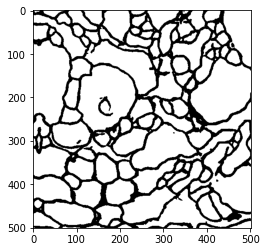

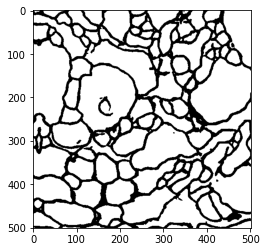

In [26]:
plt.imshow(np.argmax(seg_images[0], axis=2), cmap='gray')
plt.show()

plt.imshow(masked_images[0], cmap= 'gray')
plt.show()

In [55]:
IOUs = []
pixel_errors = []

for i in range(0, len(cropped_labels)):
  IOUs.append(intersection_over_union(masked_images[i], cropped_labels[i]))
  pixel_errors.append(pixel_error(masked_images[i], cropped_labels[i]))

print(sum(IOUs)/len(IOUs))
print(sum(pixel_errors)/len(pixel_errors))

0.8828172726481104
0.09473303559215566


In [0]:
small_val_dpath = "/content/split-tiny-augmented-segmentation-challenge-data/test_5x"
small_val_labels_dpath = "/content/split-tiny-augmented-segmentation-challenge-data/test_labels_5x"

small_val_dataset = UnetDataset(small_val_dpath, small_val_labels_dpath)
small_val_dataloader = DataLoader(small_val_dataset, batch_size = 1, pin_memory = True)


In [15]:
small_net = UNet(num_classes=2, up_method='upsample', init_method='xavier')
small_net.load_state_dict(torch.load("/content/drive/My Drive/models/model_upsample_xavier_100_56_small_dataset.pth"))
small_net.cuda(0)
print()

In [0]:
small_dpath = "/content/split-tiny-augmented-segmentation-challenge-data/train_5x"
small_labels_dpath = "/content/split-tiny-augmented-segmentation-challenge-data/train_labels_5x"

small_dataset = UnetDataset(small_dpath, small_labels_dpath)
small_training_set, small_test_set = torch.utils.data.random_split(small_dataset, [math.floor(0.8 * len(small_dataset)), math.ceil(0.2 * len(small_dataset))])

small_train_loader = DataLoader(small_training_set, batch_size = 1, pin_memory = True)
small_test_loader = DataLoader(small_test_set, batch_size = 1, pin_memory = True)

In [59]:
criterion = nn.CrossEntropyLoss()
get_loss(small_test_loader, net, criterion)

0.04748495750957065

In [39]:
cropped_images = []
seg_images = []
masked_images = []
cropped_labels = []

for i, (image, label) in enumerate(small_val_dataloader):      
  image = image.cuda(0)
  out = small_net(image)
  out = torch.nn.functional.softmax(out)
  out = out.cpu()

  ob, oc, oh, ow = out.size()

  out = out.reshape(oc, oh, ow).permute(1,2,0).detach().numpy()

  seg_images.append(out)
  masked_images.append(mask(out))
  cropped_labels.append(center_crop_image_tensor(label, (oh, ow)).reshape(oh, ow).detach().numpy())
  cropped_images.append(center_crop_image_tensor(image.cpu().reshape(1,700,700), (oh, ow)).reshape(oh, ow).detach().numpy())



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [0]:
IOUs = []
pixel_errors = []

for i in range(0, len(cropped_labels)):
  IOUs.append(intersection_over_union(masked_images[i], cropped_labels[i]))
  pixel_errors.append(pixel_error(masked_images[i], cropped_labels[i]))

print(sum(IOUs)/len(IOUs))
print(sum(pixel_errors)/len(pixel_errors))

In [0]:
small_rotated_val_dpath = "/content/rotated-tiny-augmented-segmentation-challenge-data/test_5x"
small_rotated_val_labels_dpath = "/content/rotated-tiny-augmented-segmentation-challenge-data/test_labels_5x"

small_rotated_val_dataset = UnetDataset(small_rotated_val_dpath, small_rotated_val_labels_dpath)
small_rotated_val_dataloader = DataLoader(small_rotated_val_dataset, batch_size = 1, pin_memory = True)


In [46]:
rotated_cropped_images = []
rotated_seg_images = []
rotated_masked_images = []
rotated_cropped_labels = []

for i, (image, label) in enumerate(small_rotated_val_dataloader):      
  image = image.cuda(0)
  out = small_net(image)
  out = torch.nn.functional.softmax(out)
  out = out.cpu()

  ob, oc, oh, ow = out.size()

  out = out.reshape(oc, oh, ow).permute(1,2,0).detach().numpy()

  rotated_seg_images.append(out)
  rotated_masked_images.append(mask(out))
  rotated_cropped_labels.append(center_crop_image_tensor(label, (oh, ow)).reshape(oh, ow).detach().numpy())
  rotated_cropped_images.append(center_crop_image_tensor(image.cpu().reshape(1,700,700), (oh, ow)).reshape(oh, ow).detach().numpy())



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [48]:
rotated_IOUs = []
rotated_pixel_errors = []

for i in range(0, len(rotated_cropped_labels)):
  rotated_IOUs.append(intersection_over_union(rotated_masked_images[i], rotated_cropped_labels[i]))
  rotated_pixel_errors.append(pixel_error(rotated_masked_images[i], rotated_cropped_labels[i]))

print(sum(rotated_IOUs)/len(rotated_IOUs))
print(sum(rotated_pixel_errors)/len(rotated_pixel_errors))

0.84334516134348
0.12522074945252543


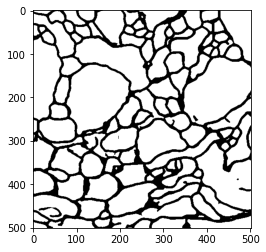

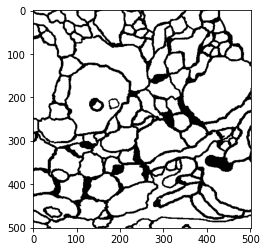

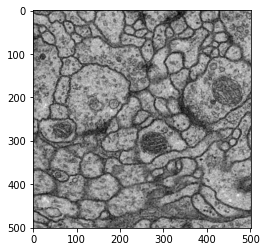

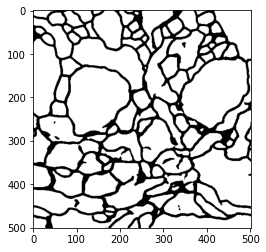

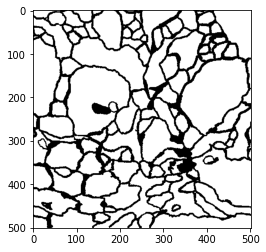

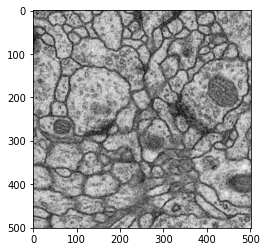

In [24]:
plt.imshow(seg_images[0][:,:,1], cmap='gray')
plt.savefig(f"/content/drive/My Drive/segmented2.png")
plt.show()

plt.imshow(cropped_labels[0], cmap='gray')
plt.savefig(f"/content/drive/My Drive/label2.png")
plt.show()

plt.imshow(cropped_images[0], cmap='gray')
plt.savefig(f"/content/drive/My Drive/image2.png")
plt.show()

plt.imshow(seg_images[1][:,:,1], cmap='gray')
plt.savefig(f"/content/drive/My Drive/segmented3.png")
plt.show()

plt.imshow(cropped_labels[1], cmap='gray')
plt.savefig(f"/content/drive/My Drive/label3.png")
plt.show()

plt.imshow(cropped_images[1], cmap='gray')
plt.savefig(f"/content/drive/My Drive/image3.png")
plt.show()




# Discussion

## Implementation Choices
- some choices we made came from confusion about the paper
- others about stuff that didn't work
- also here mention the questions we sent the authors (that sadly went unanswered)

## Results

# Future Work